In [991]:
import sys
sys.path.append('../')
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import torch.nn.functional as F
from torch.fft import fft2, ifft2, fftshift, ifftshift
import galsim
from models.Richard_Lucy import Richard_Lucy
from models.Tikhonet import Tikhonet
from models.Unrolled_ADMM import Unrolled_ADMM, InitNet, ResUNet
from utils.utils_test import PSNR, estimate_shear_new
from utils.utils_data import down_sample, get_flux

%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"] = '2'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [992]:
fov_pixels = 48                     # Number of pixels in FOV, the size of the image is (fov_pixels, fov_pixels).
pixel_scale = 0.2                   # Pixel scale (aresec), determines the resolution (0.2 for LSST).
upsample = 4                        # Upsample factor for the images.

psf_delta = np.zeros([fov_pixels, fov_pixels])
psf_delta[int(fov_pixels/2)-1,int(fov_pixels/2)-1] = 1

In [993]:
exp_time = 30.                      # Exposure time (2*15 seconds).
sky_brightness = 20.48              # Sky brightness (absolute magnitude) in i band.
zero_point = 27.85                  # Instrumental zero point, i.e. asolute magnitude that would produce one e- per second.
gain = 2.3                          # CCD Gain (e-/ADU).
qe = 0.94                           # CCD Quantum efficiency.
read_noise = 8.8                    # Standrad deviation of Gaussain read noise (e-/pixel).

sky_level_pixel = get_flux(ab_magnitude=sky_brightness, exp_time=exp_time, zero_point=zero_point, gain=gain, qe=qe) * pixel_scale ** 2
print('sky_level_pixel: {:.2f}'.format(sky_level_pixel))

sky_level_pixel: 349.47


In [994]:
# Initialize catalog
COSMOS_dir = '/mnt/WD6TB/tianaoli/COSMOS_23.5_training_sample/' # path to your COSMOS data.
# real_galaxy_catalog = galsim.RealGalaxyCatalog(dir=COSMOS_dir, sample="23.5")
real_galaxy_catalog = galsim.RealGalaxyCatalog(sample="23.5")

# Pick a galaxy
gal_idx = 0 # Galaxy index in the catalog
gal_ori = galsim.RealGalaxy(real_galaxy_catalog, index=gal_idx)
psf_hst = real_galaxy_catalog.getPSF(gal_idx)

In [995]:
random_seed = 31415
rng_base = galsim.BaseDeviate(seed=random_seed)
rng = galsim.UniformDeviate(seed=random_seed) # U(0,1).
rng_defocus = galsim.GaussianDeviate(rng_base, mean=0., sigma=0.36) # N(0,0.36).
rng_gaussian = galsim.GaussianDeviate(rng_base, mean=0., sigma=0.07) # N(0,0.07).
# The FWHM of the PSF, namely the atmospheric seeing.
fwhms = np.array([0.45, 0.55, 0.65, 0.75, 0.85, 0.95])
freqs = np.array([0., 20., 17., 13., 9., 0.])
fwhm_table = galsim.LookupTable(x=fwhms, f=freqs, interpolant='spline')
fwhms = np.linspace(fwhms[0],fwhms[-1],100) # Upsample the distribution.
freqs = np.array([fwhm_table(fwhm) for fwhm in fwhms]) / fwhm_table.integrate() # Normalization.
rng_fwhm = galsim.DistDeviate(seed=rng_base, function=galsim.LookupTable(x=fwhms, f=freqs, interpolant='spline'))

In [996]:
# Atmospheric PSF
atmos_fwhm = rng_fwhm()             # Atmospheric seeing (arcsec), the FWHM of the Kolmogorov function.
atmos_e = 0.01 + 0.02 * rng()       # Ellipticity of atmospheric PSF (magnitude of the shear in the “distortion” definition), U(0.01, 0.03).
atmos_beta = 2. * np.pi * rng()     # Shear position angle (radians), N(0,2*pi).

# Optical PSF
opt_defocus = rng_defocus()         # Defocus (wavelength), N(0.0.36).
opt_a1 = rng_gaussian()             # Astigmatism (like e2) (wavelength), N(0.0.07).
opt_a2 = rng_gaussian()             # Astigmatism (like e1) (wavelength), N(0.0.07).
opt_c1 = rng_gaussian()             # Coma along y axis (wavelength), N(0.0.07).
opt_c2 = rng_gaussian()             # Coma along x axis (wavelength), N(0.0.07).
spher = rng_gaussian()              # Spherical aberration (wavelength), N(0.0.07).
trefoil1 = rng_gaussian()           # Trefoil along y axis (wavelength), N(0.0.07).
trefoil2 = rng_gaussian()           # Trefoil along x axis (wavelength), N(0.0.07).
opt_obscuration = 0.1 + 0.4 * rng() # Linear dimension of central obscuration as fraction of pupil linear dimension, U(0.1, 0.5).
lam_over_diam = .013 + 0.07 * rng() # Wavelength over diameter (arcsec), U(0.013, 0.083).

In [997]:
# Atmospheric PSF
atmos = galsim.Kolmogorov(fwhm=atmos_fwhm, flux=1)
atmos = atmos.shear(e=atmos_e, beta=atmos_beta*galsim.radians)

# Optical PSF
optics = galsim.OpticalPSF(lam_over_diam,
                           defocus = opt_defocus,
                           coma1 = opt_c1, coma2 = opt_c2,
                           astig1 = opt_a1, astig2 = opt_a2,
                           spher=spher, trefoil1=trefoil1, trefoil2=trefoil2,
                           obscuration = opt_obscuration,
                           flux=1)

# Convolve the two components
psf = galsim.Convolve([atmos, optics])

# Draw PSF images
# optics_psf_image = galsim.ImageF(upsample*fov_pixels, upsample*fov_pixels)
# optics.drawImage(optics_psf_image, scale=pixel_scale/upsample, method='auto')
# atmos_psf_image = galsim.ImageF(upsample*fov_pixels, upsample*fov_pixels)
# atmos.drawImage(atmos_psf_image, scale=pixel_scale/upsample, method='auto')
psf_image = galsim.ImageF(upsample*fov_pixels, upsample*fov_pixels)
psf.drawImage(psf_image, scale=pixel_scale/upsample, method='auto')
psf_image = torch.from_numpy(psf_image.array)
psf_image = torch.max(torch.zeros_like(psf_image), psf_image)

In [998]:
rng_gal_shear = galsim.DistDeviate(seed=rng, function=lambda x: x, x_min=0.01, x_max=0.05)

gal_g = rng_gal_shear()             # Shear of the galaxy (magnitude of the shear in the "reduced shear" definition), U(0.01, 0.05).
gal_beta = 2. * np.pi * rng()       # Shear position angle (radians), N(0,2*pi).
gal_mu = 1 + rng() * 0.1            # Magnification, U(1.,1.1).
theta = 2. * np.pi * rng()          # Rotation angle (radians), U(0,2*pi).
dx = 2 * rng() - 1                  # Offset along x axis, U(-1,1).
dy = 2 * rng() - 1                  # Offset along y axis, U(-1,1).

In [999]:
gal = gal_ori.rotate(theta * galsim.radians) # Rotate by a random angle
gal = gal.shear(g=gal_g, beta=gal_beta * galsim.radians) # Apply the desired shear
gal = gal.magnify(gal_mu) # Apply a magnification

# Draw galaxy image
gal_image = galsim.ImageF(upsample*fov_pixels, upsample*fov_pixels)
# try:
#     gal.drawImage(gal_image, scale=pixel_scale, offset=(dx,dy), method='auto')
# except:
gal = galsim.Convolve([psf_hst, gal]) # Convolve wth original PSF of HST to avoid FFT error
gal.drawImage(gal_image, scale=pixel_scale/upsample, offset=(dx,dy), method='auto')
gal_image = torch.from_numpy(gal_image.array)

In [1000]:
def down_sample(input, rate=4):
    weight = torch.ones([1,1,rate,rate]) / (rate**2) # Average filter.
    input = input.unsqueeze(0).unsqueeze(0)
    output = F.conv2d(input=input, weight=weight, stride=rate).squeeze(0).squeeze(0)
    return output

gal_image_down = down_sample(gal_image, rate=upsample)
psf = down_sample(psf_image, rate=upsample)

In [1001]:
snr_list = [20, 40, 100]
gt_list = []

sigma = np.sqrt(sky_level_pixel + (read_noise*qe/gain) ** 2)
for snr in snr_list:
    alpha = snr * sigma / torch.sqrt((gal_image_down**2).sum()) # Scale the flux of galaxy to meet SNR requirement.
    gt_list.append(gal_image * alpha)

In [1002]:
conv_list = []
for i, gt in enumerate(gt_list):
    conv = ifftshift(ifft2(fft2(psf_image) * fft2(gt))).real # Convolution using FFT.
    conv = down_sample(conv)
    conv = torch.max(torch.zeros_like(conv), conv) # Set negative pixels to zero.
    conv_list.append(conv)
    gt_list[i] = down_sample(gt)

In [1003]:
obs_list = []
gt_shear_list = []
for gt, conv in zip(gt_list, conv_list):
    obs = conv + torch.normal(mean=torch.zeros_like(conv), std=sigma*torch.ones_like(conv))
    # obs = torch.max(torch.zeros_like(obs), obs) # Set negative pixels to zero.
    obs_list.append((obs, estimate_shear_new(obs.clone().numpy())[2], PSNR(obs.numpy(),gt.numpy())))
    gt_shear_list.append(estimate_shear_new(gt.clone().numpy())[2])

### Richardson-Lucy

In [1004]:
n_iters = 50

rec_RLs = []
model = Richard_Lucy(n_iters=n_iters)
model.to(device)
model.eval()
for (obs, _, _), gt in zip(obs_list, gt_list):
    output = model(obs.unsqueeze(dim=0).unsqueeze(dim=0).to(device), psf.unsqueeze(dim=0).unsqueeze(dim=0).to(device))
    rec = output.squeeze(dim=0).squeeze(dim=0).cpu().numpy()
    rec_shear = estimate_shear_new(rec)[2]
    rec_psnr = PSNR(rec, gt.clone())
    rec_RLs.append((rec, rec_shear, rec_psnr))

### Tikhonet and ShapeNet

In [1005]:
rec_tiks = [[], []]
model_files = [f'../saved_models/Tikhonet_Laplacian_50epochs.pth', 
               f'../saved_models/Shapenet_Laplacian_50epochs.pth']
for idx, model_file in enumerate(model_files):
    model = Tikhonet(filter='Laplacian')
    model.to(device)
    model.eval()
    model.load_state_dict(torch.load(model_file, map_location=torch.device(device)))
    print(f'Successfully loaded in {model_file}.')

    for (obs, _, _), gt in zip(obs_list, gt_list):
        alpha = obs.mean()
        alpha = torch.Tensor(alpha.float()).view(1,1,1,1)

        output = model(obs.unsqueeze(dim=0).unsqueeze(dim=0).to(device), psf.unsqueeze(dim=0).unsqueeze(dim=0).to(device), alpha.to(device))
        rec = output.cpu().squeeze(dim=0).squeeze(dim=0).detach().numpy()
        rec_shear = estimate_shear_new(rec)[2]
        rec_psnr = PSNR(rec, gt.clone())

        rec_tiks[idx].append((rec, rec_shear, rec_psnr))

Successfully loaded in ../saved_models/Tikhonet_Laplacian_50epochs.pth.
Successfully loaded in ../saved_models/Shapenet_Laplacian_50epochs.pth.


### Unrolled ADMM

In [1006]:
iter_list = [4, 8]
rec_admm = [[],[]]
model_files = [f'../saved_models/Gaussian_PnP_ADMM_4iters_MultiScale_50epochs.pth', 
               f'../saved_models/Gaussian_PnP_ADMM_8iters_MultiScale_50epochs.pth']
for idx, (n_iters, model_file) in enumerate(zip(iter_list, model_files)):
    model = Unrolled_ADMM(n_iters=n_iters, llh='Gaussian', PnP=True)
    model.to(device)
    model.eval()
    model.load_state_dict(torch.load(model_file, map_location=torch.device(device)))
    print(f'Successfully loaded in {model_file}.')

    for (obs, _, _), gt in zip(obs_list, gt_list):
        alpha = obs.mean()
        alpha = torch.Tensor(alpha.float()).view(1,1,1,1)

        output = model(obs.unsqueeze(dim=0).unsqueeze(dim=0).to(device), psf.unsqueeze(dim=0).unsqueeze(dim=0).to(device), alpha.to(device))
        rec = output.cpu().squeeze(dim=0).squeeze(dim=0).detach().numpy()
        rec_shear = estimate_shear_new(rec)[2]
        rec_psnr = PSNR(rec, gt.clone())

        rec_admm[idx].append((rec, rec_shear, rec_psnr))

Successfully loaded in ../saved_models/Gaussian_PnP_ADMM_4iters_MultiScale_50epochs.pth.
Successfully loaded in ../saved_models/Gaussian_PnP_ADMM_8iters_MultiScale_50epochs.pth.


### Plot Images

Finally we can visualize our simulated galaxy. The histograms of the simulated images are also plotted, where vertical red dashed lines represents the sky level. The pixel values are centered at sky level and variance

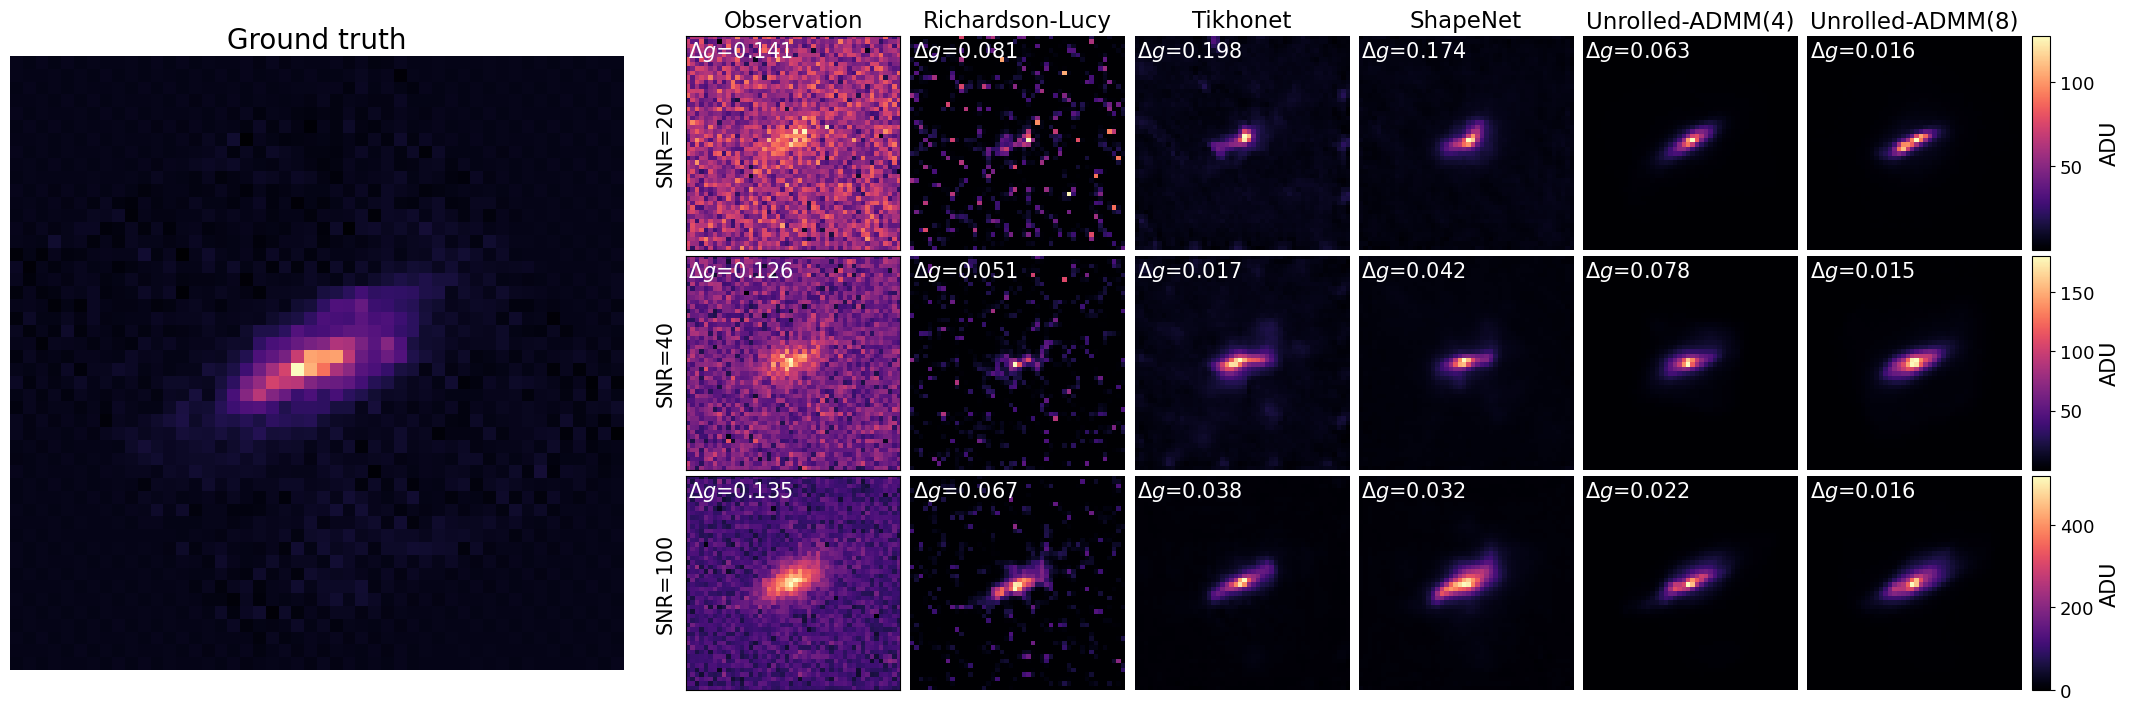

In [1007]:
fig = plt.figure(figsize=(26,8.5), facecolor='white')
ax = plt.gca()
gs = gridspec.GridSpec(6, 36)
cmap = 'magma'

plt.subplot(gs[0:6,0:11])
plt.subplots_adjust(wspace=0.06, hspace=0.06)
plt.imshow(gt_list[0], cmap=cmap)
plt.axis('off')
plt.title('Ground truth', fontsize=20)
        
for idx, (snr, obs, gt_shear, rec_RL, rec_tik, rec_shape, rec_4, rec_8) in enumerate(zip(snr_list, obs_list, gt_shear_list, rec_RLs, rec_tiks[0], rec_tiks[1], rec_admm[0], rec_admm[1])):
    vmax = np.max([obs[0].max(), rec_RL[0].max(), rec_tik[0].max(), rec_shape[0].max(), rec_4[0].max(), rec_8[0].max()])
    vmin = np.min([obs[0].min(), rec_RL[0].min(), rec_tik[0].min(), rec_shape[0].min(), rec_4[0].min(), rec_8[0].min()])
    norm = matplotlib.colors.Normalize(vmax=vmax, vmin=vmin)
    
    ax2 = plt.subplot(gs[2*idx:2*idx+2,12:16])
    plt.subplots_adjust(wspace=0.06, hspace=0.06)
    plt.imshow(obs[0], cmap=cmap)
    # plt.title("PSNR={:.1f}".format(obs[2]),x=0.525,y=0.86,loc='right', fontsize=15, color='white')
    plt.title("$\Delta g$={:.3f}".format(abs(obs[1]-gt_shear)),x=0.01,y=0.86,loc='left', fontsize=15, color='white')
    plt.ylabel("SNR={:.0f}".format(snr), fontsize=15)
    ax2.set_xticks([])
    ax2.set_yticks([])
    if idx == 0:
        plt.title('Observation', fontsize=16.5)


    ax3 = plt.subplot(gs[2*idx:2*idx+2,16:20])
    plt.subplots_adjust(wspace=0.06, hspace=0.06)
    plt.imshow(rec_RL[0], cmap=cmap)
    # plt.title("PSNR={:.1f}".format(rec_RL[2]),x=0.525,y=0.86,loc='right', fontsize=15, color='white')
    plt.title("$\Delta g$={:.3f}".format(abs(rec_RL[1]-gt_shear)),x=0.01,y=0.86,loc='left', fontsize=15, color='white')
    plt.axis('off')
    if idx == 0:
        plt.title('Richardson-Lucy', fontsize=16.5)


    ax4 = plt.subplot(gs[2*idx:2*idx+2,20:24])
    plt.subplots_adjust(wspace=0.06, hspace=0.06)
    plt.imshow(rec_tik[0], cmap=cmap)
    # plt.title("PSNR={:.1f}".format(rec_tik[2]),x=0.525,y=0.86,loc='right', fontsize=15, color='white')
    plt.title("$\Delta g$={:.3f}".format(abs(rec_tik[1]-gt_shear)),x=0.01,y=0.86,loc='left', fontsize=15, color='white')
    plt.axis('off')
    if idx == 0:
        plt.title('Tikhonet', fontsize=16.5)
        
        
    ax5 = plt.subplot(gs[2*idx:2*idx+2,24:28])
    plt.subplots_adjust(wspace=0.06, hspace=0.06)
    plt.imshow(rec_shape[0], cmap=cmap)
    # plt.title("PSNR={:.1f}".format(rec_shape[2]),x=0.525,y=0.86,loc='right', fontsize=15, color='white')
    plt.title("$\Delta g$={:.3f}".format(abs(rec_shape[1]-gt_shear)),x=0.01,y=0.86,loc='left', fontsize=15, color='white')
    plt.axis('off')
    if idx == 0:
        plt.title('ShapeNet', fontsize=16.5)


    ax6 = plt.subplot(gs[2*idx:2*idx+2,28:32])
    plt.subplots_adjust(wspace=0.06, hspace=0.06)
    plt.imshow(rec_4[0], cmap=cmap)
    # plt.title("PSNR={:.1f}".format(rec_4[2]),x=0.525,y=0.86,loc='right', fontsize=15, color='white')
    plt.title("$\Delta g$={:.3f}".format(abs(rec_4[1]-gt_shear)),x=0.01,y=0.86,loc='left', fontsize=15, color='white')
    plt.axis('off')
    if idx == 0:
        plt.title('Unrolled-ADMM(4)', fontsize=16.5)


    ax7 = plt.subplot(gs[2*idx:2*idx+2,32:36])
    plt.subplots_adjust(wspace=0.06, hspace=0.06)
    plt.imshow(rec_8[0], cmap=cmap)
    # plt.title("PSNR={:.1f}".format(rec_8[2]),x=0.525,y=0.86,loc='right', fontsize=15, color='white')
    plt.title("$\Delta g$={:.3f}".format(abs(rec_8[1]-gt_shear)),x=0.01,y=0.86,loc='left', fontsize=15, color='white')
    plt.axis('off')
    if idx == 0:
        plt.title('Unrolled-ADMM(8)', fontsize=16.5)
    cax = fig.add_axes([ax7.get_position().x1+4e-3,ax7.get_position().y0,7e-3,ax7.get_position().height])
    cb = plt.colorbar(cax=cax)
    cb.ax.tick_params(labelsize=13)
    cb.set_label('ADU',fontsize=15)
    
plt.savefig('grid.eps', bbox_inches='tight')
plt.savefig('grid.jpg', bbox_inches='tight')